<a href="https://colab.research.google.com/github/Najme61/3D-CNN-Keras/blob/master/event_227.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('Mydrive')
!ls 'Mydrive/My Drive/UCSD/UCSDped1'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at Mydrive
Test  Train


In [0]:
# preprocessing train data _event detection with 227 size
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import glob
import os 
from keras.models import load_model  
import argparse
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

image_store=[]

ped1_path = "Mydrive/My Drive/UCSD/UCSDped1/Train"
paths = os.listdir(ped1_path)

for path in paths:
    framepath = ped1_path + "/" + path
    images = os.listdir(framepath)
    for image in images:
           
            image_path = framepath + "/" + image
            img = load_img(image_path)
            img = img_to_array(img)
            img = resize(img,(227,227,3))
            g = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
            #print(g)   
            image_store.append(g)
image_store = np.array(image_store)
#image_store.shape
a, b, c = image_store.shape
        
image_store.resize(b,c,a)
#Normalize
image_store=(image_store-image_store.mean())/(image_store.std())
#Clip negative Values
image_store=np.clip(image_store,0,1)
np.save('Mydrive/My Drive/event dect/train.npy',image_store)

Using TensorFlow backend.


In [0]:
#preprocessing test data _event detection with 227 size
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import glob
import os 
from keras.models import load_model 
import argparse
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

image_store = []
    
    
#List of all Videos in the Source Directory. 
#videos=os.listdir(video_source_path)


#Make a temp dir to store all the frames
#os.mkdir(video_source_path + '/frames')
ped1_path = "Mydrive/My Drive/UCSD/UCSDped1/Test"
paths = os.listdir(ped1_path)

for path in paths:
    framepath = ped1_path + "/" + path
    
    """for video in videos:
        os.system( 'ffmpeg -i {}/{} -r 1/{} {}/frames/%03d.jpg'.format(video_source_path,video,fps,video_source_path))"""
    images = os.listdir(framepath)
    for image in images:
            #image_path = framepath + "/" + image
            image_path = framepath + "/" + image
            img = load_img(image_path)
            img = img_to_array(img)
                
                
            #Resize the Image to (224,224,3) for the network to be able to process it. 
            img = resize(img,(227,227,3))
                
            #Convert the Image to Grayscale
                
                
            g = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
                
            image_store.append(g)
            #store(image_path)


image_store = np.array(image_store)
image_store.shape
a, b, c = image_store.shape
        #Reshape to (227,227,batch_size)
image_store.resize(b,c,a)
#Normalize
image_store=(image_store-image_store.mean())/(image_store.std())
#Clip negative Values
image_store=np.clip(image_store,0,1)
np.save('Mydrive/My Drive/event dect/test.npy',image_store)
#Remove Buffer Directory
#os.system('rm -r {}'.format(framepath))


Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import numpy as np 

from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
#import argparse

''''parser=argparse.ArgumentParser()
parser.add_argument('n_epochs',type=int)

args=parser.parse_args()
'''
X_train=np.load('Mydrive/My Drive/event dect/train.npy')
frames=X_train.shape[2]
#Need to make number of frames divisible by 10
print(X_train.shape)
print(frames)

frames=frames-frames%10
print('frames',frames)
X_train=X_train[:,:,:frames]
X_train=X_train.reshape(-1,227,227,10)
X_train=np.expand_dims(X_train,axis=4)
print('X_train',X_train.shape)
Y_train=X_train.copy()
print('Y_train',Y_train.shape)

#epochs=5
#batch_size=10
#'''
model=Sequential()
#spatial encoder
model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))

model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
#temporal encoder
model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))
model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))
#temporal decoder
model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))

#spatial decoder: Transposed convolution layer (sometimes called Deconvolution)
model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
model.summary()

history= model.fit(X_train, Y_train, batch_size=1, epochs=30)
model.save("Mydrive/My Drive/event dect/AnomalyDetector.h5")

'''
#if __name__=="__main__":

#	model=load_model()
  
callback_save = ModelCheckpoint("AnomalyDetector.h5",monitor="mean_squared_error", save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)

print('Model has been loaded')
  
model.fit(X_train,Y_train,
			              batch_size=batch_size,
			              epochs=epochs,
			              callbacks = [callback_save,callback_early_stopping]
			              )'''
  

Using TensorFlow backend.


(227, 227, 6812)
6812
frames 6810
X_train (681, 227, 227, 10, 1)
Y_train (681, 227, 227, 10, 1)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 26, 26, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
____________________________________

'\n#if __name__=="__main__":\n\n#\tmodel=load_model()\n  \ncallback_save = ModelCheckpoint("AnomalyDetector.h5",monitor="mean_squared_error", save_best_only=True)\n\ncallback_early_stopping = EarlyStopping(monitor=\'val_loss\', patience=3)\n\nprint(\'Model has been loaded\')\n  \nmodel.fit(X_train,Y_train,\n\t\t\t              batch_size=batch_size,\n\t\t\t              epochs=epochs,\n\t\t\t              callbacks = [callback_save,callback_early_stopping]\n\t\t\t              )'

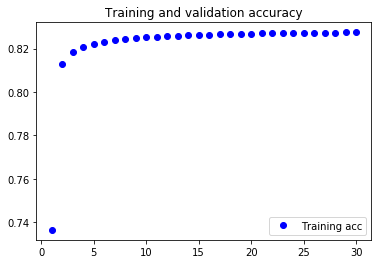

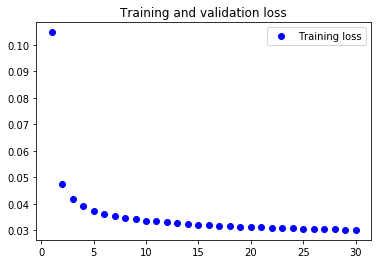

In [3]:
import matplotlib.pyplot as plt

acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [5]:
from keras.models import load_model
import numpy as np 

def mean_squared_loss(x1,x2):

	''' Compute Euclidean Distance Loss  between 
	input frame and the reconstructed frame'''

	diff=x1-x2
	a,b,c,d,e=diff.shape
	n_samples=a*b*c*d*e
	sq_diff=diff**2
	Sum=sq_diff.sum()
	dist=np.sqrt(Sum)
	mean_dist=dist/n_samples

	return mean_dist

'''Define threshold for Sensitivity
Lower the Threshhold,higher the chances that a bunch of frames will be flagged as Anomalous.
'''

threshold=0.01

model=load_model('Mydrive/My Drive/event dect/AnomalyDetector.h5')

X_test=np.load('Mydrive/My Drive/event dect/test.npy')
frames=X_test.shape[2]
#Need to make number of frames divisible by 10

flag=0 #Overall video flagq

frames=frames-frames%10

X_test=X_test[:,:,:frames]
X_test=X_test.reshape(-1,227,227,10)
X_test=np.expand_dims(X_test,axis=4)
c1=1
for number,bunch in enumerate(X_test):
	n_bunch=np.expand_dims(bunch,axis=0)
	reconstructed_bunch=model.predict(n_bunch)


	loss=mean_squared_loss(n_bunch,reconstructed_bunch)

	if loss>threshold:
		print("Anomalous bunch of frames at bunch number {}".format(number))
		flag=1


	else:
		#print('Bunch Normal')
		c1=c1+1


if flag==1:
	print("Anomalous Events detected")
print('Normal',c1) 

724


In [11]:
import matplotlib.pyplot as plt
print(n_bunch.shape,reconstructed_bunch.shape)
print(loss)
print(X_test.shape)

(1, 227, 227, 10, 1) (1, 227, 227, 10, 1)
0.00036235013179439473
(723, 227, 227, 10, 1)
